<a href="https://colab.research.google.com/github/namtoptall/DataScience/blob/main/SkimLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SkimLit

In [12]:
# Kiểm tra GPU
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


## Những gì chúng ta sẽ đề cập

Chúng ta sẽ thực hiện :

* Nhận dữ liệu chuỗi thời gian (giá lịch sử của Bitcoin)
  * Load dữ liệu chuỗi thời gian bằng mô-đun CSV của pandas/Python
* Định dạng dữ liệu cho bài toán chuỗi thời gian
  * Tạo tập huấn luyện và kiểm tra (sai cách)
  * Tạo tập huấn luyện và kiểm tra (đúng cách)
  * Trực quan hóa dữ liệu chuỗi thời gian
  * Biến dữ liệu chuỗi thời gian thành một bài toán học có giám sát (windowing)
  * Chuẩn bị dữ liệu đơn biến và đa biến (nhiều hơn một biến)
* Đánh giá mô hình dự báo chuỗi thời gian
* Thiết lập một chuỗi các thử nghiệm mô hình học sâu
  * Mạng dày đặc (được kết nối đầy đủ)
  * Mô hình chuỗi (LSTM và 1D CNN)
  * Ensembling (kết hợp nhiều mô hình với nhau)
  * Mô hình đa biến
  * Sao chép thuật toán N-BEATS bằng cách sử dụng phân lớp TensorFlow layer
* Tạo modelling checkpoint để lưu mô hình hoạt động tốt nhất trong quá trình huấn luyện
* Đưa ra dự đoán (dự báo) với mô hình chuỗi thời gian
* Tạo khoảng thời gian dự đoán cho các dự báo mô hình chuỗi thời gian
* Thảo luận về hai loại không chắc chắn khác nhau trong ML (data uncertainty và model uncertainty)
* Chứng minh lý do tại sao dự báo trong một hệ thống mở là BS (bài toán gà tây)

In [13]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [14]:
# Kiểm tra xem có những file nào trong tập dữ liệu PubMed_20K
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [15]:
# Bắt đầu sử dụng tập dữ liệu 20k
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [16]:
# Kiểm tra tất cả filename trong directory đích
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Tiền xử lý dữ liệu

In [17]:
def get_lines(filename):
    with open(filename, "r") as f:
        return f.readlines()

In [20]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [27]:
def preprocess_text_with_line_numbers(filename):
    input_lines = get_lines(filename)
    abstract_lines = ""
    abstract_samples = []
    for line in input_lines:
        if line.startswith("###"):
            abstract_id = line
            abstract_lines = ""
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                target_text_split = abstract_line.split("\t")
                line_data["target"] = target_text_split[0]
                line_data["text"] = target_text_split[1].lower()
                line_data["line_number"] = abstract_line_number
                line_data["total_lines"] = len(abstract_line_split)
                abstract_samples.append(line_data)
        else:
            abstract_lines += line
    return abstract_samples

In [28]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev là một tên gọi khác của validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 456 ms, sys: 151 ms, total: 607 ms
Wall time: 616 ms


(180040, 30212, 30135)

In [30]:
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [31]:
# turn the dictionaries into pandas
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(10)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,12
1,METHODS,a total of @ patients with primary knee oa wer...,1,12
2,METHODS,outcome measures included pain reduction and i...,2,12
3,METHODS,pain was assessed using the visual analog pain...,3,12
4,METHODS,secondary outcome measures included the wester...,4,12
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,12
6,RESULTS,there was a clinically relevant reduction in t...,6,12
7,RESULTS,the mean difference between treatment arms ( @...,7,12
8,RESULTS,"further , there was a clinically relevant redu...",8,12
9,RESULTS,these differences remained significant at @ we...,9,12


In [32]:
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

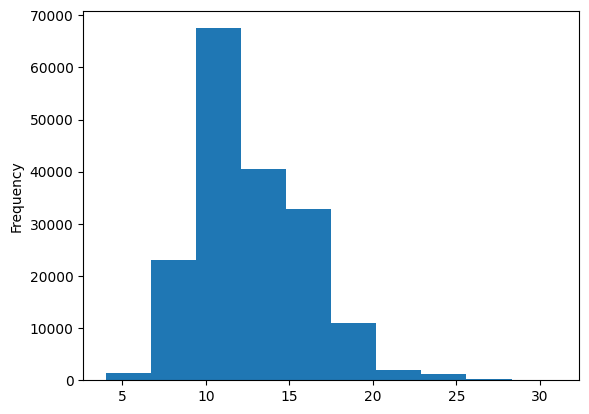

In [34]:
train_df.total_lines.plot.hist()

In [35]:
train_sentences = train_df.text.tolist()
val_sentences = val_df.text.tolist()
test_sentences = test_df.text.tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [36]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [38]:
val_sentences[:10]

['ige sensitization to aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .',
 'it is not clear whether these patients would benefit from antifungal treatment .',
 'we sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are ige sensitized to a fumigatus .',
 'asthmatic patients who were ige sensitized to a fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .',
 'primary outcomes were improvement in quality of life at the end of the treatment period and a reduction in the number of severe exacerbations over the @ months of the study .',
 'sixty-five patients were randomized .',
 'fifty-nine patients started treatment ( @ receiving voriconazole and @ receiving plac

In [39]:
test_sentences[:10]

['this study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( adhf ) .',
 'a post hoc analysis was conducted with the use of data from the evaluation study of congestive heart failure and pulmonary artery catheterization effectiveness ( escape ) .',
 'liver function tests ( lfts ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .',
 'survival analyses were used to assess the association between admission model of end-stage liver disease excluding international normalized ratio ( meld-xi ) scores and patient outcome.there was a high prevalence of abnormal baseline ( admission ) lfts ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .',
 "the percentage of patients with abnormal lfts decreased significantly from baseline to @-months ' follow-up .",
 'when mean hemodynamic profiles were compared in patients with abnormal versus 

## Tạo nhãn dạng số (mô hình học máy cần các nhãn dạng số)

In [65]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Kiểm tra xem các nhãn huấn luyện trông như thế nào
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [43]:
# Trích xuất nhãn (cột "target") và mã hóa chúng thành số nguyên
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Kiểm tra xem nhãn huấn luyện trông như thế nào
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [44]:
num_classes = len(label_encoder.classes_)
class_name = label_encoder.classes_
class_name, num_classes

(array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object),
 5)

## Model 0: Tạo mô hình cơ sở
Mô hình đầu tiên của chúng ta sẽ là TF-IDF Multinomial Naive Bayes, theo gợi ý từ [machine learning map của Scikit-Learn](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).

Để xây dựng, chúng ta sẽ tạo `Pipeline` của Scikit-Learn, sử dụng lớp [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) để chuyển đổi các câu abstract thành số bằng cách sử dụng thuật toán TF-IDF, sau đó tìm hiểu cách phân loại các câu bằng cách sử dụng thuật toán [`MultinomialNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# create the pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
    ("clf", MultinomialNB()) # model the text
])
# fir the model pipeline
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [46]:
model_0.score(train_sentences, train_labels_encoded)

0.7516829593423684

In [47]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [48]:
# downlaod support functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-07-30 19:39:03--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-07-30 19:39:04 (51.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [49]:
from helper_functions import calculate_results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Chuẩn bị dữ liệu cho các mô hình chuỗi sâu


In [50]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [51]:
# find the average length of the sentences
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

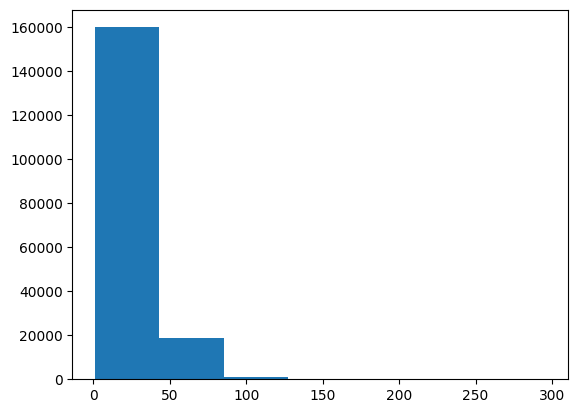

In [52]:
# plot the distribution ""
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=7);

In [54]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [55]:
max(sent_lens)

296

In [56]:
max_tokens = 68000

In [57]:
# create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=55)

In [58]:
text_vectorizer.adapt(train_sentences)

In [59]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}\n")
print(f"Vectorized: {text_vectorizer([target_sentence])}")


Text:
a total of @ patients including @ in the k-flap group and @ in the ehsi group were included in the study .

Vectorized: [[    8    76     4    12   251     5     2 22729    13     3     5     2
  26716    13     9   121     5     2    17     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [61]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Top 5 words: {rct_20k_text_vocab[:5]}")
print(f"Bottom 5 words: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Top 5 words: ['', '[UNK]', 'the', 'and', 'of']
Bottom 5 words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [62]:
# Tìm cấu hình của text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [63]:
# create token embedding layer
token_embed = layers.Embedding(
    input_dim=len(rct_20k_text_vocab),
    output_dim=128,
    mask_zero=True,
    name="token_embedding" )

# print the embeddings
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization:\n{vectorized_sentence}\n")
print(f"Output shape: {token_embed(vectorized_sentence).shape}")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Embedded sentence:\n{embedded_sentence}")

Sentence before vectorization:
a total of @ patients including @ in the k-flap group and @ in the ehsi group were included in the study .

Sentence after vectorization:
[[    8    76     4    12   251     5     2 22729    13     3     5     2
  26716    13     9   121     5     2    17     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Output shape: (1, 55, 128)
Embedded sentence:
[[[-0.0015311  -0.03190521  0.01430558 ...  0.01302173 -0.03174154
   -0.03905756]
  [-0.01803879 -0.03503876 -0.03311697 ... -0.043022    0.00542038
    0.03105384]
  [-0.03966125  0.03830136 -0.02226951 ...  0.0465298  -0.01640854
    0.02446366]
  ...
  [ 0.03102518 -0.04642245 -0.02310087 ...  0.04541905 -0.02117788
    0.03391144]
  [ 0.03102518 -0.04642245 -0.02310087 ...  0.04541905 -0.02117788
    0.03391144]
  [ 0.03102518 -0.046

In [67]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [68]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE )
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>